# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -1.991538  0.875350  1.0  0.164110 -1.926389  0.995412  1  3  14.340256   
1 -0.171753  1.634480  1.0  0.919815 -0.433193  0.663405  0  1  22.693028   
2  1.171627  1.212421  1.0  0.464170 -0.561284 -1.507529  2  0  16.448280   
3 -1.290717  1.318248  1.0  0.609479  0.105058  0.328869  1  0  18.500401   
4  0.636588  0.779073  1.0  0.147014 -2.339601 -0.562032  2  1   8.037758   

            y  
0   34.820887  
1  317.304510  
2  329.215481  
3  130.802007  
4  128.365278  
True causal estimate is 11.049366904703493


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

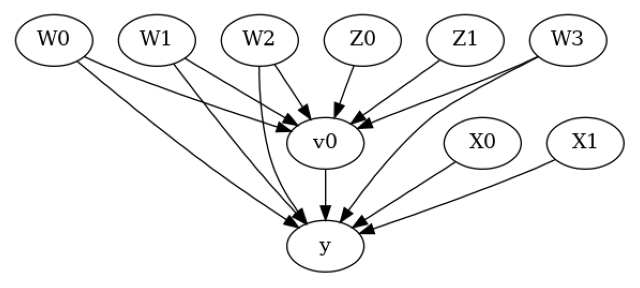

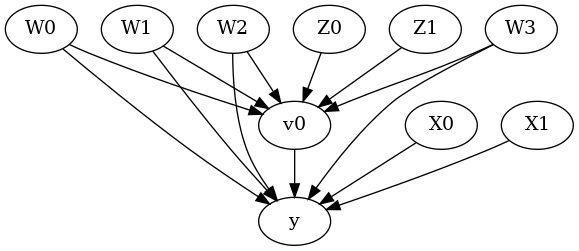

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1+v0*X1+v0*X0
Target units: 

## Estimate
Mean value: 11.049360385238776
### Conditional Estimates
__categorical__X1  __categorical__X0
(-3.125, -0.168]   (-3.725, -1.018]     -0.483267
                   (-1.018, -0.421]      4.096752
                   (-0.421, 0.0937]      6.868820
                   (0.0937, 0.679]       9.932541
                   (0.679, 3.412]       14.523653
(-0.168, 0.408]    (-3.725, -1.018]      2.009778
                   (-1.018, -0.421]      6.643759
                   (-0.421, 0.0937]      9.529690
                   (0.0937, 0.679]      12.346536
                   (0.679, 3.412]    

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 19.942961669168422
Effect estimates: [[19.95274169]
 [20.31592716]
 [23.69560739]
 ...
 [22.42989348]
 [19.67935212]
 [26.62660787]]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.049366904703493


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X1,X0
Target units: 

## Estimate
Mean value: 10.965996095314368
Effect estimates: [[ 1.86231293]
 [13.76967748]
 [19.692277  ]
 ...
 [10.57950429]
 [ 6.79891405]
 [ 6.10624249]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 11.014889706769777
Effect estimates: [[ 1.71069711]
 [13.83758805]
 [19.90290692]
 ...
 [10.64301205]
 [ 6.71858225]
 [ 6.17851456]]
95.0% confidence interval: [[[ 1.38382682 13.94156069 20.15627721 ... 10.72297109  6.54540283
    5.99948106]]

 [[ 1.75654442 14.24828998 20.58524929 ... 10.91585351  6.94104706
    6.57550946]]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[15.28422787]
 [11.41825742]
 [13.60900361]
 [12.87138923]
 [16.48649368]
 [15.2148538 ]
 [17.15296726]
 [14.66329601]
 [11.30331747]
 [15.54577995]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=1, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        W0        W1        W2        W3  v0  y
0     0.080306  2.247467  0.0 -2.401206 -1.312561 -1.480329  2.047774   0  0
1     1.367558  0.586367  1.0 -1.358703 -2.837270  0.115695  2.503531   1  1
2     0.177830  1.273005  0.0 -0.564442 -2.044971  0.942301  2.369456   0  1
3    -0.234802 -0.061610  0.0 -0.647182 -1.853970 -0.122606  1.357227   0  0
4     0.617971 -0.770328  0.0 -0.919695 -2.034157 -1.336222  0.637247   0  0
...        ...       ...  ...       ...       ...       ...       ...  .. ..
9995  1.076904  0.892264  0.0  0.827704 -0.913141 -0.635722  1.653019   0  1
9996  1.537854  2.209320  1.0 -0.654308 -0.133276  1.759450  1.699000   1  1
9997  0.961166  0.441278  1.0 -1.181845 -1.051911  0.633985  0.040985   1  1
9998  0.524581  1.288320  1.0 -1.264843  0.505249 -1.210057  1.283382   1  1
9999  2.364454  1.444651  0.0 -0.743766 -0.580996 -1.946981  1.307697   0  0

[10000 rows x 9 columns]


#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 0.620597765219284
Effect estimates: [[0.74208753]
 [0.69322759]
 [0.66739089]
 ...
 [0.65264217]
 [0.69294463]
 [0.83481414]]

True causal estimate is 0.612


### Instrumental Variable Method

In [16]:
dmliv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.dml.DMLIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{
                                                              'discrete_treatment':False,
                                                              'discrete_instrument':False
                                                             },
                                               "fit_params":{}})
print(dmliv_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 13.04986382188787
Effect estimates: [[13.97198977]
 [19.95679009]
 [15.81903988]
 ...
 [11.03872038]
 [10.79531079]
 [ 6.35065782]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.568028  1.603632 -0.005652 -1.084619  0.493585  1.0  0.092269   
1    -0.773305 -0.140293 -0.191275  0.448917  1.964407  1.0  0.174272   
2    -0.362693  0.201271 -0.259677 -1.332344  2.458435  1.0  0.380207   
3    -1.050170 -2.466052 -0.626156 -0.968446  2.195057  1.0  0.436562   
4    -2.844955 -0.103096 -0.552799 -0.472557  1.638181  1.0  0.267798   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.974497 -0.282811 -0.939197 -0.657467  0.745450  1.0  0.641891   
9996  0.964895 -0.144748 -0.668310  0.296311 -0.310493  1.0  0.276371   
9997 -3.551671 -1.029147 -0.917950 -0.348049  1.387120  1.0  0.212345   
9998 -3.245241  0.406376  0.459365 -0.601041  1.756991  1.0  0.663181   
9999 -0.852817  1.297501 -0.400761 -0.710965  0.825339  1.0  0.621874   

            W0        W1        W2        W3        W4  v0          y  
0    -1.156709  0.740386 -0.006841  0.421232 -0.697

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W0,W2,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W0,W2,W1,U) = P(y|v0,W3,W4,W0,W2,W1)

## Realized estimand
b: y~v0+X3+X4+X0+X2+X1+W3+W4+W0+W2+W1
Target units: ate

## Estimate
Mean value: 5.70958768783081
Effect estimates: [[ 7.76502323]
 [11.50787668]
 [ 6.69033901]
 ...
 [-0.79801433]
 [ 7.65604191]
 [ 8.15060339]]

True causal estimate is 3.746159232004771


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W0,W2,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W0,W2,W1,U) = P(y|v0,W3,W4,W0,W2,W1)

## Realized estimand
b: y~v0+X3+X4+X0+X2+X1+W3+W4+W0+W2+W1
Target units: Data subset provided as a data frame

## Estimate
Mean value: 6.053369369833126
Effect estimates: [[ 3.76901408]
 [11.4892018 ]
 [-0.79801433]
 [ 7.65604191]
 [ 8.15060339]]

True causal estimate is 3.746159232004771


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.354958630024644
New effect:14.3876445826865
p value:0.52



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.354958630024644
New effect:14.449117605376458



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.354958630024644
New effect:0.010948110564111518
p value:0.43422339335230575



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.354958630024644
New effect:14.361211651688734
p value:0.4664384377185818



More refutation methods to come, especially specific to the CATE estimators.